In [1]:
#install statsmodels
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 34.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
#download file
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-01-11 02:03:55--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-01-11 02:03:55 (39.2 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [3]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#buat dataframe
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

#display 5 data teratas
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


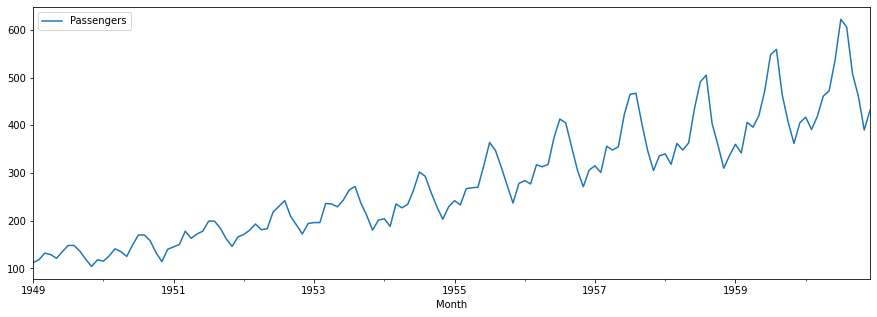

In [4]:
#buat plot passengers
df.plot(figsize=(15,5))

In [5]:
# buat kolom baru untuk menghitung jarak hari
df['lstdiff'] = df['Passengers'].diff() #diff untuk menghitung jarak hari

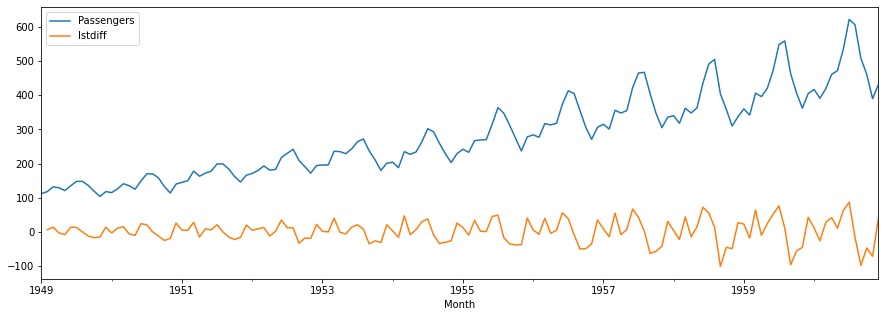

In [6]:
#buat plot terbaru
df.plot(figsize=(15,5))

In [7]:
#buat kolom baru untuk mengisi nilai log dari passengers
df["LogPassengers"] = np.log(df["Passengers"])

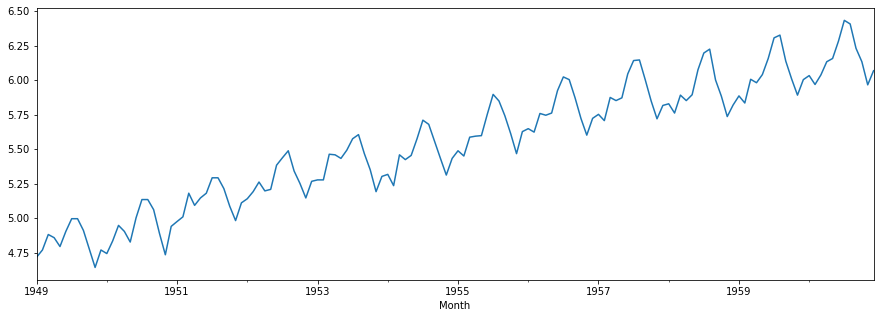

In [8]:
#buat plot dari kolom terbaru
df["LogPassengers"].plot(figsize=(15,5))

In [9]:
#import ARIMA
from statsmodels.tsa.arima.model import ARIMA

#set index freq menjadi "MS"
df.index.freq="MS"

#buat variable
Ntest = 12 #ini akan jadi jumlah datatesting
train = df.iloc[:-Ntest] #akan diisi data training dengan diatas tail(12)
test = df.iloc[-Ntest:] #akan diisi data testing dengan tail(12)

In [10]:
#buat variable dengan nilai boolean
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [11]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [12]:
arima_result = arima.fit()

In [13]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(
    start=train.index[0], end=train.index[-1]
)

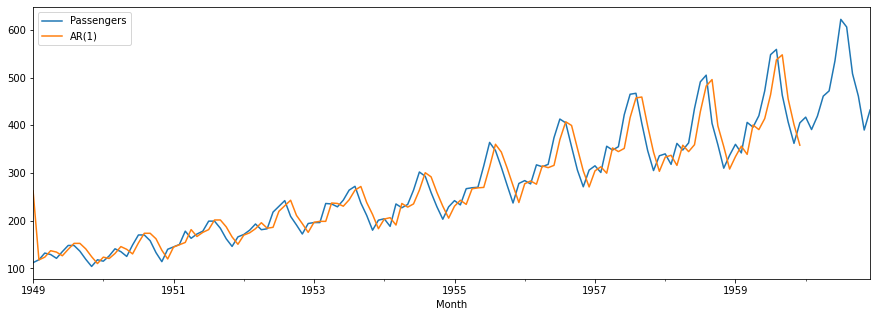

In [14]:
df[['Passengers', 'AR(1)']].plot(figsize=(15,5))

In [15]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

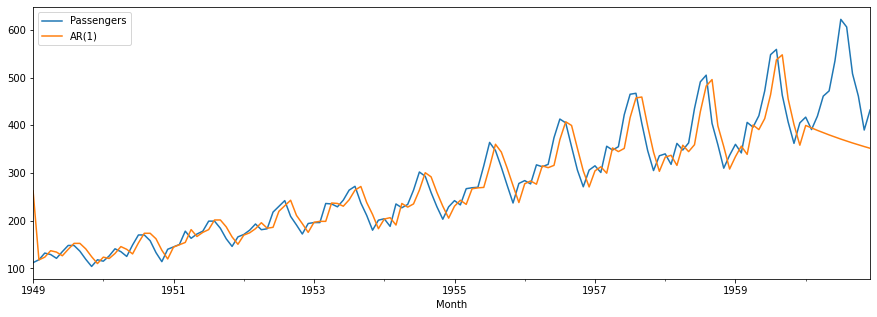

In [16]:
df[['Passengers', 'AR(1)']].plot(figsize=(15,5))

Plot di atas kurang bagus dibandingkan dengan plot yang di atasnya lagi, karena diakhir plot ternyata trendnya menunjukan penurunan. Sehingga dapat dibilang tidak sesuai

In [17]:
#cek tipe prediksinya
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [18]:
#cek confidence interval
prediction_result.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829380
1960-04-01,269.338255,499.534230
1960-05-01,253.432283,506.121348
1960-06-01,239.373402,511.217438
1960-07-01,226.768867,515.201639
1960-08-01,215.354569,518.324977
1960-09-01,204.941149,520.764225
1960-10-01,195.386336,522.649550


In [19]:
#buat fungsi
def plot_fit_and_forecast(result):
  # 1. plot untuk passengers
  fig, ax = plt.subplots(figsize=(15,5)) #15 = kolom, dan 5 = baris
  ax.plot(df['Passengers'], label='data')

  # 2. plot untuk nilai fit
  #buat curve plot di data training
  train_pred = result.fittedvalues
  ax.plot(train.index, train_pred, color='grey', label='fitted')

  # 3. plot untuk forecast
  #forecast untuk data testing
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()

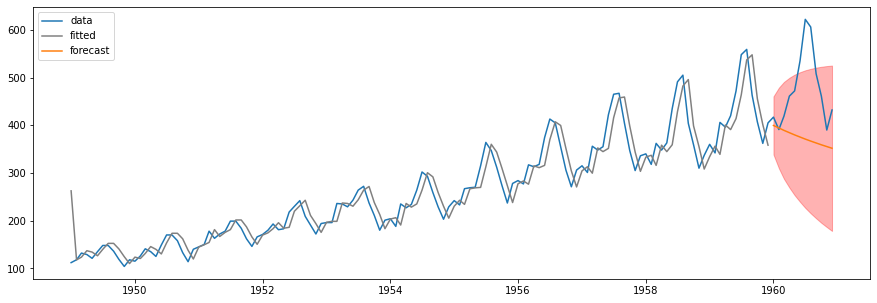

In [20]:
# tes fungsi dengan arima_result
plot_fit_and_forecast(arima_result)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


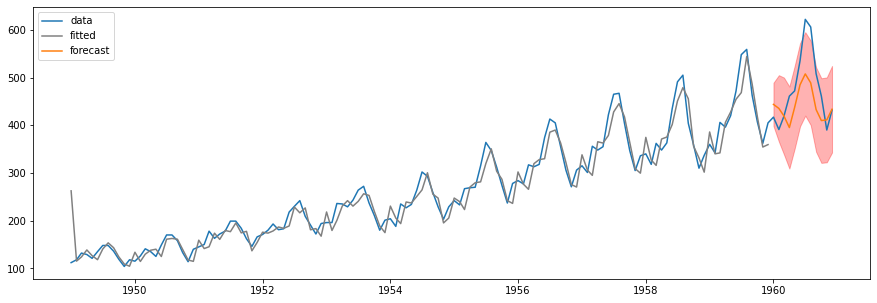

In [21]:
#buat arima_result menjadi AR10
arima = ARIMA(train['Passengers'], order=(10,0,0)) #AR10
arima_result = arima.fit()

#tes dengan menggunakan fungsi kembali
plot_fit_and_forecast(arima_result)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


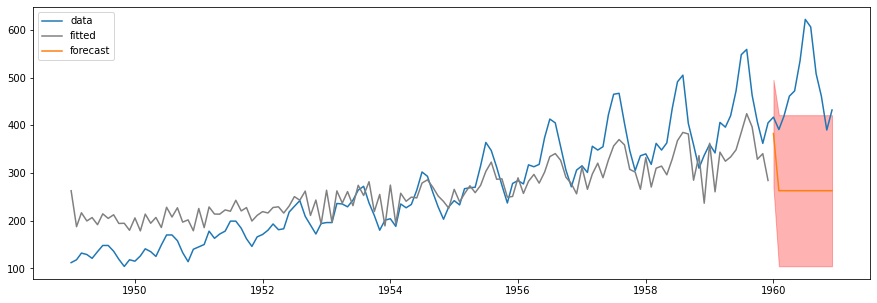

In [22]:
#buat arima_result menjadi AR10
arima = ARIMA(train['Passengers'], order=(0,0,1)) #MA1
arima_result = arima.fit()

#tes dengan menggunakan fungsi kembali
plot_fit_and_forecast(arima_result)

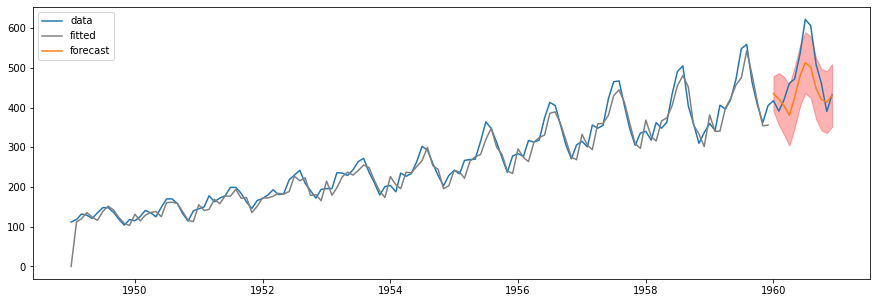

In [23]:
#buat arima_result menjadi ARIMA811
arima = ARIMA(train['Passengers'], order=(8,1,1)) #ARIMA811
arima_result = arima.fit()

#tes dengan menggunakan fungsi kembali
plot_fit_and_forecast(arima_result)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


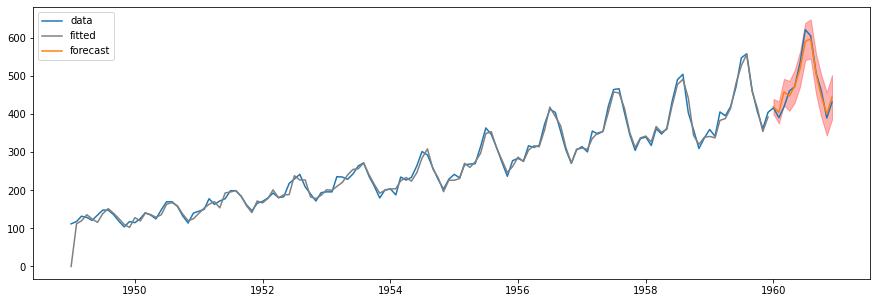

In [24]:
#buat arima_result menjadi ARIMA1210
arima = ARIMA(train['Passengers'], order=(12,1,0)) #ARIMA1210
arima_result = arima.fit()

#tes dengan menggunakan fungsi kembali
plot_fit_and_forecast(arima_result)

In [25]:
df['LoglstDiff'] = df['LogPassengers'].diff()

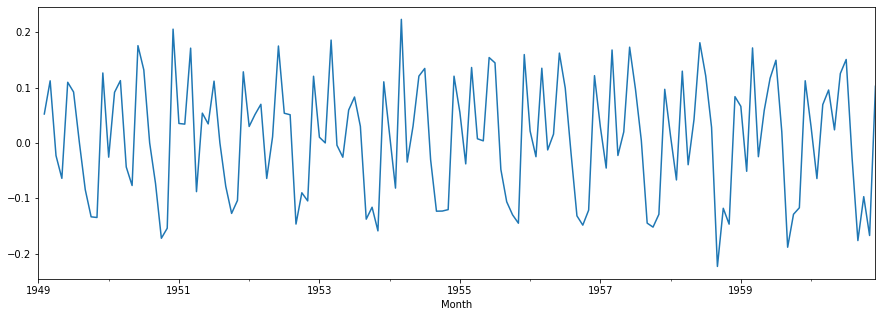

In [26]:
df['LoglstDiff'].plot(figsize=(15,5))

In [27]:
def rmse(result, is_logged):
  forecast = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)
  
  t = test['Passengers']
  y = forecast
  return np.sqrt(np.mean((t-y)**2))

# Error

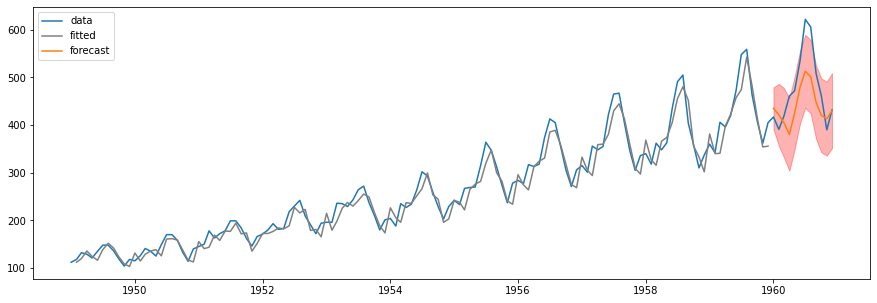

In [31]:
arima = ARIMA(train['Passengers'], order=(8,1,1))
arima_result_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col='Passengers'):
  fix, ax = plt.subplots(figsize=(15,5))
  ax.plot(df[col], label='data')

  #curve plot
  train_pred = result.predict(start=train.index[d], end=train.index[-1])
  ax.plot(train.index[d:], train_pred, color='grey', label='fitted')

  #forecast plot
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
  
  ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

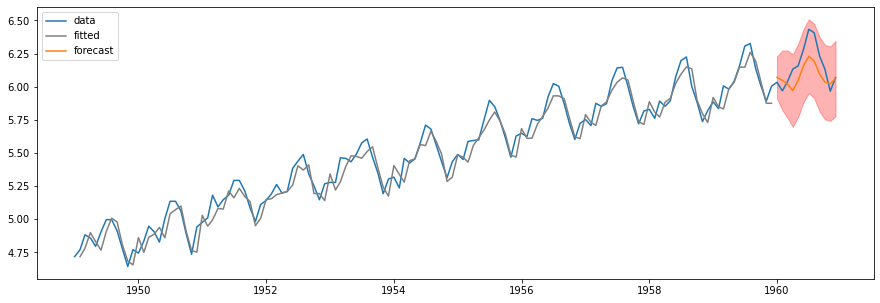

In [33]:
arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


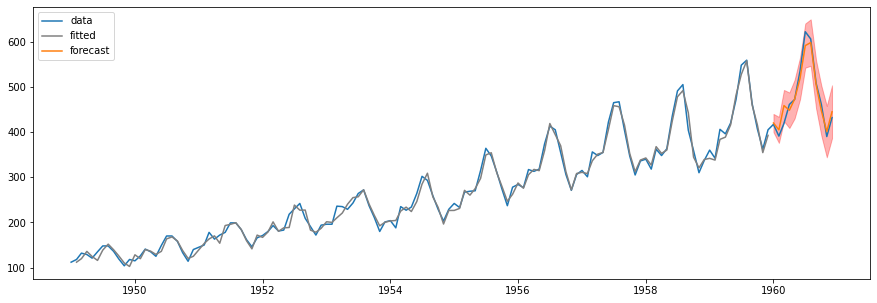

In [38]:
arima = ARIMA(train['Passengers'], order=(12,1,0))
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, col='Passengers')

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


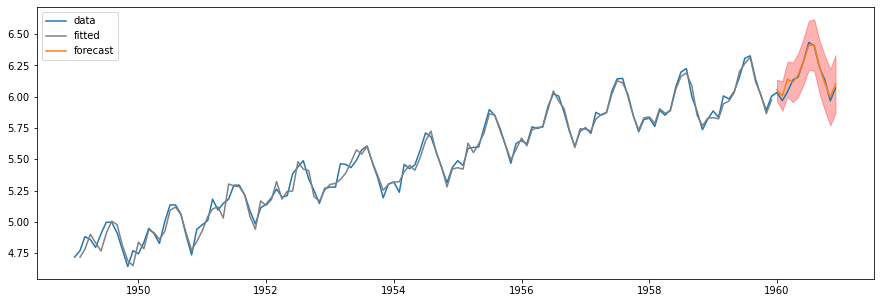

In [39]:
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

In [40]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0):", rmse(arima_result_log1210, False))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 59.06459099216811
ARIMA(8,1,1) logged: 61.6060499311999
ARIMA(12,1,0): 475.83390985559845
ARIMA(12,1,0) logged: 16.173491680975104
